<!-- ![RWTH Logo](https://www.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaaaaagazb) -->
![iAMB Logo](https://www.iamb.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaaaanwtny)
# Calculations of Substrate and Production Rates and Yields

* Execute a single cell: <span class="fa-play fa"></span>
* Execute all cells: Menu: Run <span class="fa-chevron-right fa"></span> Run All Cells
* To reboot kernel: <span class="fa-refresh fa"></span>

Find more in the reference (menu: Help <span class="fa-chevron-right fa"></span> Jupyter Reference).

In [24]:
import os
import pandas as pd
import glob
# import numpy as np
from datetime import date
from scipy import stats
from IPython.utils import io
import ipywidgets as widgets


import matplotlib.pyplot as plt
%matplotlib inline

from cobra.io import read_sbml_model, write_sbml_model
from iambcodes.cobra import *
from iambcodes.rates import *
# for flux visualization with Escher
from escher import Builder

Today = date.today().strftime('%y%m%d')

print('Libraries loaded.')

Libraries loaded.


## Data loading and variables setup
The workflow can be initiated with parameters from a separate, previously generated config file. If no config file exists, leave the corresponding variable `ConfFile` empty.

In [27]:
# Load existing configuration file, or leave the list empty
ConfFile = ''
Workflow = 'GSMMSim'
# Comment for the config file
ConfComment = '# This file contains the parameters used for growth and substrate rate analysis.'
if ConfFile:
    print('Loading analysis config file:')
    Par_Dict = read_ConfFile(ConfFile)
    if Par_Dict['Workflow']==Workflow:
        print('Configuration file fits workflow.')
    else:
        print('ERROR: Configuration file of parameters not suited for the workflow.')
        ConfFile = ''
        
# For automatic reading of directory, e.g. in cloud use:
# Root_Dir = os.path.join(os.getcwd().split(os.sep)[:-1])
Target_Dir = os.path.join('..', 'Data', 'GSMM') if not ConfFile else Par_Dict['Target_Dir']
File = 'iUma22.xml' # 'iUma22.xml' if not ConfFile else Par_Dict['File']
FileAddress = os.path.join(Target_Dir, File)

# Output Files
# Choose image file type, e.g. svg, png, pdf, eps
ImageType = 'svg' if not ConfFile else Par_Dict['ImageType']

with io.capture_output() as captured:
    model = read_sbml_model(FileAddress)
    
model

<Model UMAY at 0x7f5fb1e66580>

In [28]:
model.summary()

## Flux visualization with Escher maps
The flux visualization requires custom made Escher maps. The visualization is stored as a separate html-file.

In [29]:
EscherMapDirectory = os.path.join(Target_Dir, 'EscherMaps')
Escher_Central = os.path.join(EscherMapDirectory,'iUma22_MetMap_TCA.json')
Escher_Glycine = os.path.join(EscherMapDirectory,'iUma22_MetMap_glycine.json')
builder = Builder(
    map_json=Escher_Central,
    model = model, # 'iCL1079.json',
)
# Run FBA with the model and add the flux data to the map
solution = builder.model.optimize()
builder.reaction_data = solution.fluxes

builder.save_html(os.path.join(Target_Dir,'example_map.html'))

## Substrate tests
In the following code, the model is tested for growth rates on defined substrates and the corresponding uptake rates.

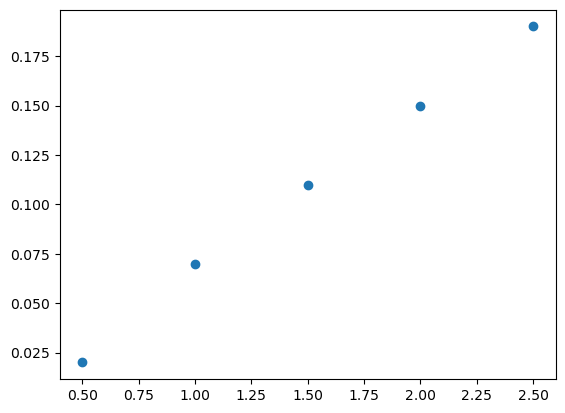

In [30]:
SubNames = ['EX_glc__D_e','EX_glc__D_e','EX_glc__D_e','EX_glc__D_e','EX_glc__D_e']
SubRates = [.5, 1, 1.5, 2, 2.5]

Growth = list()
for myName, myRate in zip(SubNames, SubRates):
    Growth.append(TestSubstrate(model, EX_Sub_Act=[myName], EX_Sub_Off=['EX_glc__D_e'], Rate=myRate))
    
plt.xlabel('Substrate Rate [mmol/gDW/h]')
plt.ylabel('Growth Rate [1/h]')
plt.plot(SubRates, Growth, 'o')

## Plotting simulation and measured growth
Experimental data from the file `RatesCompare.xlsx` in the sub-directory `GSMM` is used to evaluate the quality of the model predictions.

In the following cells, the file name and the names of the columns are defined.

In [31]:
# File with different substrate uptake and growth rates
RatesFile = 'RatesCompare.xlsx'
RatesFile = os.path.join(Target_Dir, RatesFile)
RatesSheet = 'RateCompare'
# Decide which substrate to examine, glucose: glc, glycerol: glyc, acetate: ace
SubType = 'Substrate' if not ConfFile else Par_Dict['SubType']
# SubUnit = 'g/L' if not ConfFile else Par_Dict['SubUnit']
# SubstrateCorr =  [mol2g[SubType]  if SubUnit=='g/L' else 1.]
# Data rows to be ignored, list with names according to ID column
IgnoreDat = ['2196_glc','2196_glyc'] if not ConfFile else Par_Dict['IgnoreDat']
# Define names of columns for analysis
GrowthMean = 'Growth-Rate[/h]' if not ConfFile else Par_Dict['GrowthMean']
GrowthStdv = 'Growth-Std' if not ConfFile else Par_Dict['GrowthStdv']
SubstrMean = 'Substrate-uptake[mmol/gCDW/h]' if not ConfFile else Par_Dict['SubstrMean']
SubstrStdv = 'Uptake-Std' if not ConfFile else Par_Dict['SubstrStdv']
SubstrInit = 'Initial Conc[g/L]' if not ConfFile else Par_Dict['SubstrInit']
GSMMRctName = 'Rct-Name'if not ConfFile else Par_Dict['GSMMRctName']
# Typically GSMM have by default a substrate uptake activated. This should be deactivated to check experimental substrates.
EX_Sub_Off=['EX_glc__D_e']

FigureExpSimGrw = os.path.join(Target_Dir, '{}_{}_Growth-ExpVsSim.{}'.format(Today, os.path.splitext(os.path.split(RatesFile)[1])[0], ImageType))

In the following cell the visualization is performed.

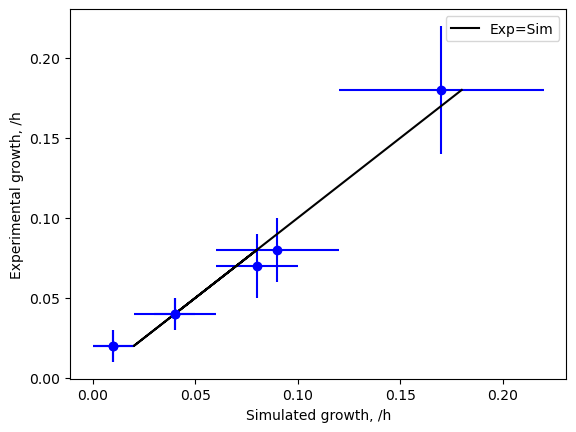

Growth rate versus substrate uptake figure saved as ../Data/GSMM/230531_RatesCompare_Growth-ExpVsSim.svg


In [32]:
RateComp = pd.read_excel(RatesFile, sheet_name=RatesSheet)

IgnoreDat = np.ravel([list(RateComp.index[IgnoreCheck == RateComp['ID']]) for IgnoreCheck in IgnoreDat])
# ExchRct_dict = {'glucose':'EX_glc__D_e', 'glycerol':'EX_glyc_e'}
SubColl = list()

# ignoring any data points
if IgnoreDat is not None:
    RateComp_corr = RateComp.drop(IgnoreDat)
else:
    RateComp_corr = RateComp

SubColl = np.unique(RateComp_corr[SubType])
color = plt.cm.brg(np.linspace(0,1,len(SubColl)))
GrDat = list()
SubDat = list()
    
for Indx, Exp in RateComp_corr.iterrows():
    SubstrateType = Exp[SubType]
    myEX = Exp[GSMMRctName]
    myRate = Exp[SubstrMean]
    myRateMax = Exp[SubstrMean] + Exp[SubstrStdv]
    SimGrowth = TestSubstrate(model, EX_Sub_Act=[myEX], EX_Sub_Off=EX_Sub_Off, Rate=myRate) #+myRate
    tmp_std = TestSubstrate(model, EX_Sub_Act=[myEX], EX_Sub_Off=EX_Sub_Off, Rate=myRateMax)
    SimGrowth_std = tmp_std - SimGrowth
    ExpGrowth = Exp[GrowthMean]
    ExpGrowth_std = Exp[GrowthStdv]
    plt.errorbar(SimGrowth, ExpGrowth, yerr=ExpGrowth_std, xerr=SimGrowth_std, color=color[list(SubColl).index(SubstrateType)], fmt='o')
    GrDat.append(ExpGrowth)
    SubDat.append(myRate)


plt.plot(RateComp_corr[GrowthMean],RateComp_corr[GrowthMean], '-k')
plt.ylabel('Experimental growth, /h')
plt.xlabel('Simulated growth, /h')
plt.legend(['Exp=Sim'])

plt.savefig(FigureExpSimGrw)
plt.show()
print('Growth rate versus substrate uptake figure saved as {}'.format(FigureExpSimGrw))


### Optimization of growth associated maintenance on growth data

Growth data over different values of substrate uptake rates enable the optimization of the growth associated maintenance (GAM) energy requirement. Simulations are performed for all experiments and the optimization selects the GAM value that minimizes the error.

In [33]:
import re
from scipy import optimize

Data = RateComp.corr[['Substrate-uptake[mmol/gCDW/h]','Growth-Rate[/h]']].values
ChangeStoich = {'atp_c', 'adp_c', 'h_c', 'pi_c'}   

def GAMEQ(GAMVAL, model=model, Data=Data, BM_ID='BIOMASS_REACTION', ChangeStoich=ChangeStoich, EX_Sub_Act=['EX_glc__D_e']):
    GAMVAL = float(GAMVAL)
    BM_EQ_Ref = model.reactions.get_by_id(BM_ID).reaction
    for myMet in ChangeStoich:
        BM_EQ = re.sub(r'\d+\.\d+\ +{}'.format(myMet), '{} {}'.format(GAMVAL, myMet), BM_EQ_Ref)
    SubDat = Data[:,0]
    GrDat = Data[:,1]
    SimGr = list()
    SSR = list()
    with model:
        model.reactions.get_by_id(BM_ID).build_reaction_from_string(BM_EQ)
        for myGlc,myGr in zip(SubDat, GrDat):
            SimGr = TestSubstrate(model, EX_Sub_Act=EX_Sub_Act, EX_Sub_Off=['EX_co2_e'], Rate =myGlc)
            SSR.append((myGr-SimGr)**2)
#     RSS = np.sum((myGr-np.array(SimGr))**2)
#     print(RSS)
    return np.sum(SSR)
minimum = optimize.fmin(GAMEQ,32)
print('optimal GAM: {}'.format(minimum[0]))

optimal GAM: 32.0


/tmp/ipykernel_12658/3787551483.py:22: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  minimum = optimize.fmin(GAMEQ,32)
